In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
import json

# Load dataset
input = sc.textFile("data/dataset_fornite.json")
data = input.flatMap(lambda x: x.split("\n")).map(lambda x: json.loads(x))

print("\nFirst record: "+format(data.first()))


# Top 10 wins
top_wins = data.map(lambda x: (x["name"], x["stats"]["overview"]["wins"])) \
                .reduceByKey(lambda a, b: a + b)
print("\nTop 10 wins: "+format(top_wins.takeOrdered(10,key=lambda t: -t[1])))


# User win percentage
win_percentage = data.map(lambda x: (x["name"], (x["stats"]["overview"]["wins"], \
                                                 x["stats"]["overview"]["matches"]))) \
                        .aggregateByKey((0.0, 0.0), \
                                        (lambda x, y: (y[0]*100, x[1] + y[1])), \
                                        (lambda x, y: (x[0] + y[0], x[1] + y[1]))) \
                        .mapValues(lambda x: (x[0] / x[1]))
                
print("\nUser win percentage: "+format(win_percentage.takeOrdered(10,key=lambda t: -t[1])))


# User kills-deaths ratio (kills/(matches-wins))
kill_deaths = data.map(lambda x: (x["name"], (x["stats"]["overview"]["kills"], \
                                              x["stats"]["overview"]["matches"], \
                                              x["stats"]["overview"]["wins"]))) \
                .aggregateByKey((0.0, 0.0), \
                                (lambda x, y: (x[0] + y[0], y[1] - y[2])), \
                                (lambda x, y: (x[0] + y[0], x[1] + y[1]))) \
                .mapValues(lambda x: (x[0] / x[1]) if x[1] != 0 else x[0])

print("\nUser kills-deaths ratio: "+format(kill_deaths.takeOrdered(10,key=lambda t: -t[1])))

# Info for specific user
ninja = data.filter(lambda x: x["name"] == "Ninja")
print("\nInfo for user Ninja: "+format(ninja.collect()))


# Total kills of the dataset
total_kills = data.map(lambda x: x["stats"]["overview"]["kills"]) \
                    .reduce(lambda a, b: a + b)
print("\nTotal kills: "+format(total_kills))


# Percentage of top 10 won
top10wins = data.map(lambda x: (x["name"], (x["stats"]["overview"]["wins"], \
                                            x["stats"]["overview"]["top10"]))) \
                .filter(lambda x: x[1][0] > 2000 and float(x[1][0]) / float(x[1][1]) > 0.5) \
                .mapValues(lambda x: (float(x[0]) / float(x[1])))
print("\n% of TOP10 games that are WON (>2000 wins): " + \
      format(top10wins.takeOrdered(10,key=lambda t: -t[1])))



First record: {u'stats': {u'overview': {u'top10': 207, u'kills': 2118, u'kd': 1.62, u'matches': 1341, u'wins': 37, u'top25': 426, u'win_p': 2.76}, u'squads-pc': {u'top10': 1, u'kills': 14, u'kd': 0.5, u'matches': 28, u'wins': 0, u'top25': 3, u'win_p': 0.0}, u'solo-pc': {u'top10': 195, u'kills': 1932, u'kd': 1.73, u'matches': 1152, u'wins': 35, u'top25': 391, u'win_p': 3.04}, u'duos-pc': {u'top10': 11, u'kills': 172, u'kd': 1.08, u'matches': 161, u'wins': 2, u'top25': 32, u'win_p': 1.24}}, u'name': u'-Mantis-'}

Top 10 wins: [(u'AlexRamiGaming', 3532), (u'TAYLOR_IS_ME', 3160), (u'JeDiiiKniiGhT', 3158), (u'Twitch_Svennoss', 3070), (u'Ninja', 3030), (u'NinjasHyper.V2', 3030), (u'Yt_burningbagel', 3017), (u'SinnersDemise', 2860), (u'FT_Fateu', 2857), (u'Fnatic_Ettnix', 2829)]

User win percentage: [(u'NewkuXD', 100.0), (u'RazZzero0oRank1', 84.61538461538461), (u'HAODM', 81.57894736842105), (u'Twitch_Orcas', 75.67567567567568), (u'C4Brandon.TTv', 74.48979591836735), (u'TwitchRazZzero0o', 7

In [45]:
players_by_platform = {}

def filter_by_platform(mode, platform):
    gamemode = "{}-{}".format(mode, platform)
    
    players_by_platform[mode][platform] = data.filter(lambda x: gamemode in x["stats"] ) \
                                 .map(lambda x: (x["name"], (x["stats"][gamemode]["wins"], \
                                                             x["stats"][gamemode]["kills"], \
                                                             x["stats"][gamemode]["kd"], \
                                                             x["stats"][gamemode]["top10"])))


for mode in ["solo", "duos", "squads"]:
    players_by_platform[mode] = {} 
    for platform in ["pc", "ps4", "xbox"]:
        filter_by_platform(mode, platform)
        


# Top 10 solo wins by platform
for platform in ["pc", "ps4", "xbox"]:
    top_wins = players_by_platform["solo"][platform].map(lambda x: (x[0], x[1][0])) \
                                                .reduceByKey(lambda a, b: a + b)
    print("\nTop 10 WINS {} {}: ".format("solo", platform)+ \
          format(top_wins.takeOrdered(10,key=lambda t: -t[1])))


Top 10 WINS solo pc: [(u'twitch_bogdanakh', 2323), (u'Twitch_Svennoss', 2315), (u'twitchtv_eXzacT7', 2124), (u'SypherPK', 2020), (u'TSM_Hamlinz', 1716), (u'NV_KR', 1696), (u'Twitch_Agares29', 1668), (u'TTV_WishYouLuckk', 1538), (u'TSM_Myth', 1536), (u'VaxitylolMIXERtv', 1471)]

Top 10 WINS solo ps4: [(u'AlexRamiGaming', 3466), (u'JeDiiiKniiGhT', 2466), (u'TTV_MBaty', 2395), (u'Sp3cialForce21', 1994), (u'Jayvz1', 1604), (u'B\u7ad9 Xiao_512', 1586), (u'AlmightySneaky', 1547), (u'Infamous Coconut', 1545), (u'joethebroo', 1246), (u'Jambonlol', 1212)]

Top 10 WINS solo xbox: [(u'LvL99Miggs', 175), (u'OneMoonMan', 130), (u'jmo022', 121), (u'XxMoNkEyBuTTxX5', 118), (u'Periphelion', 103), (u'iiSemper', 102), (u'TasteTheRambo03', 100), (u'Dark Longaniza', 97), (u'Dr. Juul', 90), (u'JOKER4565', 70)]


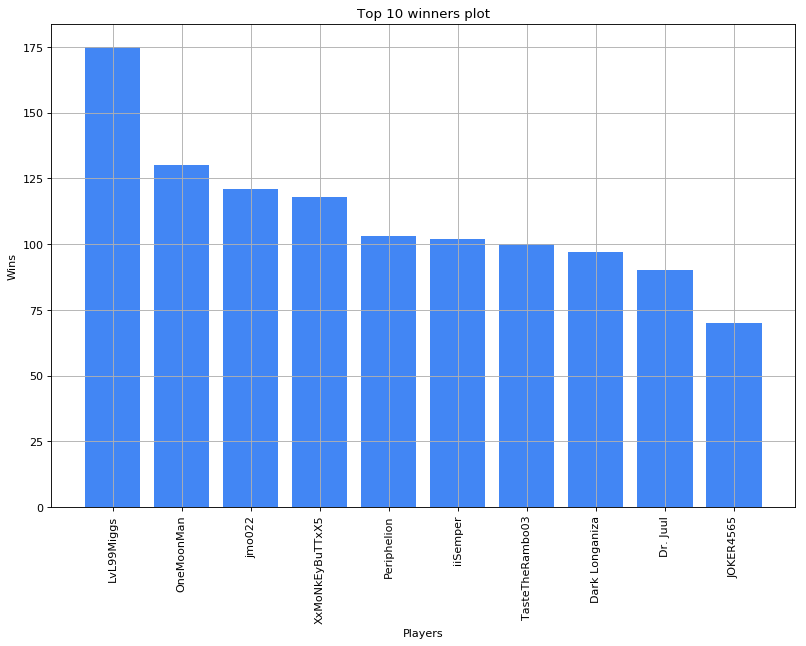

In [101]:
import matplotlib.pyplot as plt

# Top 10 winners plot

players = sc.parallelize(top_wins.takeOrdered(10,key=lambda t: -t[1])) \
                        .map(lambda l: l[0]).collect()
wins = sc.parallelize(top_wins.takeOrdered(10,key=lambda t: -t[1])) \
                        .map(lambda l: l[1]).collect()

plt.figure(figsize=(12,8), dpi=80, facecolor='white', edgecolor='k')
plt.bar(players, wins, 0.8, color='#4286f4', label='Men means')
      
plt.xlabel('Players')
plt.ylabel('Wins')
plt.grid()
plt.title('Top 10 winners plot')
plt.xticks(players, players, rotation='vertical')

plt.show()